In [30]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.set_option('display.float_format', '{:.6f}'.format)

import statsmodels.api as sm # type: ignore
from linearmodels.panel import RandomEffects # type: ignore
pd.options.mode.chained_assignment = None  # default='warn'
from linearmodels import PooledOLS # type: ignore


In [31]:
def OLS(X,y): 
    return np.linalg.pinv(X.T @ X) @ (X.T @ y)

def FGLS(X,y, estimated_omega): 
    return np.linalg.pinv(X.T@ np.linalg.pinv(estimated_omega) @ X) @ (X.T @np.linalg.pinv(estimated_omega)@ y)

def residuals(x,y,beta):
    y_pred = x @ beta  
    return y - y_pred 

def standard_errors_OLS(X, res): 
    n = X.shape[0]
    k = X.shape[1]
    if n-k == 0 : 
        return [0, 0]
    else: 
        sigma_squared = (res.T @ res)/ (n-k) 
        var_beta_hat = sigma_squared * np.linalg.pinv(X.T @ X)
        se = np.sqrt(np.diag(var_beta_hat))
        return se.ravel()

def t_statistics(beta_hat, se):
    
    return beta_hat / se

def results_OLS(X,y,xvars):
    beta_hat = OLS(X,y)
    res = residuals(X,y,beta_hat)
    se = standard_errors_OLS(X, res)
    tstat = t_statistics(beta_hat, se)

   
    results_df = pd.DataFrame({
            'Beta': beta_hat,
            'Standard Error': se,
            't-stat': tstat
    }, index=xvars)
 
    return beta_hat, se, tstat, res, results_df

def standard_errors_FGLS(X,y, res, omega):
    k = X.shape[1]
    n = len(y)
    weightedresid = res.T @ np.linalg.pinv(omega)@ res
    sigma_hat_squared = weightedresid/(n-k) 
    return np.sqrt(np.diag(sigma_hat_squared *(np.linalg.pinv(X.T@ np.linalg.pinv(omega) @ X)))).reshape(-1,1)

def results_FGLS(X,y,omega, xvars):
    beta_hat = FGLS(X,y,omega)
    res = residuals(X,y,beta_hat)
    se = standard_errors_FGLS(X,y,res,omega).ravel()
    tstat = t_statistics(beta_hat, se)
    
    results_df = pd.DataFrame({
            'Beta': beta_hat,
            'Standard Error': se,
            't-stat': tstat
        }, index=xvars)

    return beta_hat, se, tstat, res, results_df

def get_omega_fgls(residuals): 
    variance = np.var(residuals, ddof=1)  
    covariance_matrix = np.diag(np.full(residuals.shape[0], variance))  
    return covariance_matrix

In [32]:
pre_data = pd.read_excel("econ229incomedemocracy.xlsx")
pre_data = pre_data[["country", "year", "code_numeric","year_numeric","fhpolrigaug","lrgdpch"]]

countries = list(pre_data["country"].drop_duplicates())

"""For each country, how many countries has consecutively complete data?""" 
countries_11 = []
for i in range(0, len(countries)):
    df = pre_data[pre_data["country"] == countries[i]]
    nulls_in_both = df[['fhpolrigaug', 'lrgdpch']].isnull().any().any()
    if not nulls_in_both:
    # if not nulls_in_both and countries[i] != "Belgium" and countries[i]!= "Denmark"and countries[i]!= "Iceland" and countries[i]!= "Netherlands" and countries[i]!= "Norway" and countries[i]!= "New Zealand":
        countries_11.append(countries[i])

pre_data = pre_data.set_index(['code_numeric', 'year_numeric']).sort_index()
df = pre_data[pre_data['country'].isin(countries_11)]
time_invariant_data = pd.read_excel("countries.xlsx")
seas_dict = time_invariant_data.set_index('country')['Seas'].to_dict()
df["majorseas"] = df['country'].map(seas_dict)

# Random Effects Model 

In [33]:
y = df['fhpolrigaug']
X = df[['lrgdpch', 'majorseas']]
X = sm.add_constant(X)  

model = RandomEffects(y, X)
re_results = model.fit()

print(re_results.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:            fhpolrigaug   R-squared:                        0.1277
Estimator:              RandomEffects   R-squared (Between):              0.5973
No. Observations:                 363   R-squared (Within):              -0.0245
Date:                Sun, Oct 20 2024   R-squared (Overall):              0.3116
Time:                        12:31:43   Log-likelihood                    82.340
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      26.352
Entities:                          33   P-value                           0.0000
Avg Obs:                       11.000   Distribution:                   F(2,360)
Min Obs:                       11.000                                           
Max Obs:                       11.000   F-statistic (robust):             26.352
                            

## OLS

In [34]:
y = df['fhpolrigaug']
X = df[['lrgdpch', 'majorseas']]
X = sm.add_constant(X)  

mod = PooledOLS(y, X)
res = mod.fit()
print(res.resids)

code_numeric  year_numeric
6             31             -0.269038
              32             -0.471928
              33             -0.156223
              34             -0.278263
              35             -0.665039
                                ...   
208           37             -0.486600
              38             -0.483670
              39             -0.482452
              40              0.199165
              41              0.190565
Name: residual, Length: 363, dtype: float64


In [35]:
y = df['fhpolrigaug']
x = df[['lrgdpch', 'majorseas']]
xvars = ["cons", 'lrgdpch', 'majorseas']

X = np.column_stack([np.ones(x.shape[0]), x])
beta_hat_ols_RE, se_ols_RE, tstat_ols_RE, res_ols_RE, results_df_ols_RE = results_OLS(X,y, xvars)

print(results_df_ols_RE)
print(res_ols_RE)

               Beta  Standard Error    t-stat
cons      -1.004151        0.134610 -7.459722
lrgdpch    0.198947        0.014675 13.557307
majorseas  0.018677        0.009844  1.897279
code_numeric  year_numeric
6             31             -0.269038
              32             -0.471928
              33             -0.156223
              34             -0.278263
              35             -0.665039
                                ...   
208           37             -0.486600
              38             -0.483670
              39             -0.482452
              40              0.199165
              41              0.190565
Name: fhpolrigaug, Length: 363, dtype: float64


## FGLS

In [ ]:
Omega = get_omega_fgls(res_ols_RE)
beta_hat_RE, se_RE, tstat_RE, res_RE, results_df_RE = results_FGLS(X,y,Omega, xvars)
print(results_df_RE)

print("\n")

model = sm.OLS(y, X)
re_results = model.fit()

print(re_results.summary()) 

               Beta  Standard Error    t-stat
cons      -1.004151        0.134610 -7.459722
lrgdpch    0.198947        0.014675 13.557307
majorseas  0.018677        0.009844  1.897279


                            OLS Regression Results                            
Dep. Variable:            fhpolrigaug   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     92.10
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           4.99e-33
Time:                        12:31:43   Log-Likelihood:                 42.359
No. Observations:                 363   AIC:                            -78.72
Df Residuals:                     360   BIC:                            -67.04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef   

## Checking for correlation between errors and independent variables

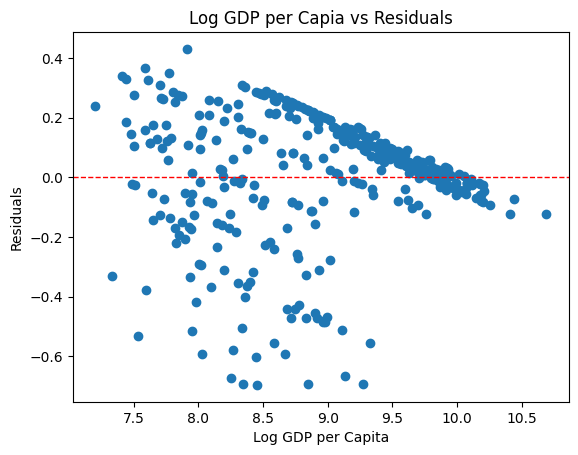

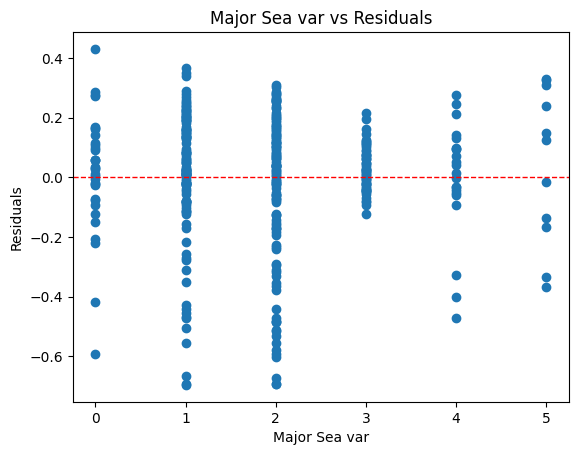

In [37]:
x_1 = df['lrgdpch']
plt.scatter(x_1, res_RE)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  
plt.title("Log GDP per Capia vs Residuals")
plt.xlabel("Log GDP per Capita")
plt.ylabel("Residuals")
plt.show()

x_2 = df['majorseas']
plt.scatter(x_2, res_RE)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  
plt.title("Major Sea var vs Residuals")
plt.xlabel("Major Sea var")
plt.ylabel("Residuals")
plt.show()

# Fixed Effects Model 

## Within Transformation Estimator (Fixed Effects)

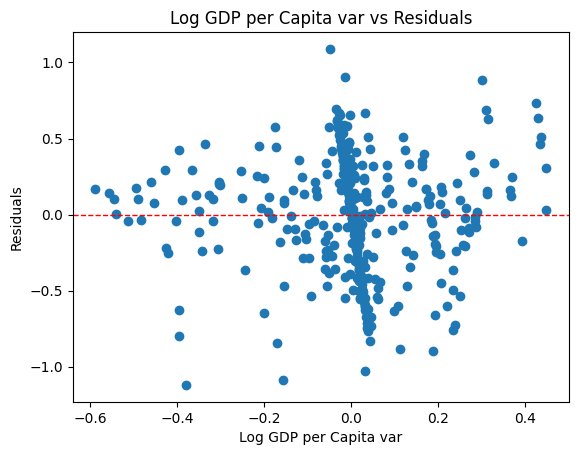

                      Beta  Standard Error    t-stat
cons             -0.000000        0.009390 -0.000000
lrgdpch_centered  0.051668        0.025082  2.059951


                             OLS Regression Results                             
Dep. Variable:     fhpolrigaug_centered   R-squared:                       0.012
Model:                              OLS   Adj. R-squared:                  0.009
Method:                   Least Squares   F-statistic:                     4.243
Date:                  Sun, 20 Oct 2024   Prob (F-statistic):             0.0401
Time:                          12:31:44   Log-Likelihood:                 110.63
No. Observations:                   363   AIC:                            -217.3
Df Residuals:                       361   BIC:                            -209.5
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std 

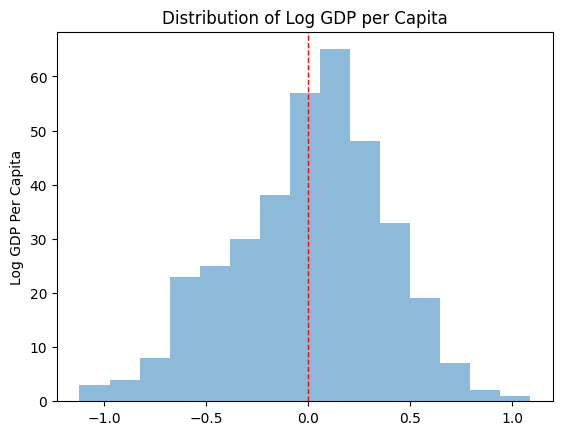

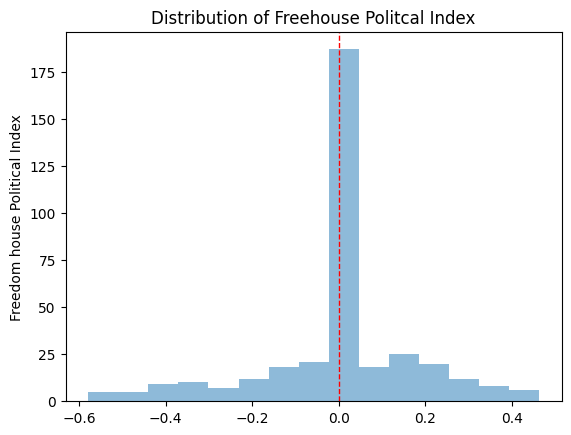

In [38]:
within_df = df.copy()
country_list = list(within_df["country"].drop_duplicates()) 

for i in range(0, len(country_list)): 
    country = country_list[i]
    current_df = within_df[within_df["country"] == country]
    y = current_df['fhpolrigaug']
    x = current_df[['lrgdpch', 'majorseas']]
    y_average = y.mean(axis=0)
    x_average = x.mean(axis=0)

    y_centered = y - y_average
    x_centered = x - x_average
    
    # Replace values in the original DataFrame
    within_df.loc[within_df["country"] == country, 'fhpolrigaug_centered'] = y_centered
    within_df.loc[within_df["country"] == country, 'lrgdpch_centered'] = x_centered['lrgdpch']
    within_df.loc[within_df["country"] == country, 'majorseas_centered'] = x_centered['majorseas']

y = within_df['fhpolrigaug_centered']
x = within_df['lrgdpch_centered']
X = np.column_stack([np.ones(x.shape[0]), x])

xvars= ["cons", 'lrgdpch_centered']
beta_hat_ols_FE, se_ols_FE, tstat_ols_FE, res_ols_FE, results_df_ols_FE = results_OLS(X,y, xvars)

plt.scatter(res_ols_FE, within_df["lrgdpch_centered"])
plt.axhline(0, color='red', linestyle='--', linewidth=1)  
plt.title("Log GDP per Capita var vs Residuals")
plt.xlabel("Log GDP per Capita var")
plt.ylabel("Residuals")
plt.show()

Omega = get_omega_fgls(res_ols_FE)

beta_hat_FE, se_FE, tstat_FE, res_FE, results_df_FE  = results_FGLS(X,y,Omega,xvars)
print(results_df_FE)
print("\n")

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


mean = x.mean()
plt.title("Distribution of Log GDP per Capita")
plt.ylabel("Log GDP Per Capita")
plt.hist(x, bins = 15, alpha=0.5)
plt.axvline(mean, color='red', linestyle='--', linewidth=1)  
plt.plot
plt.show()

mean = y.mean()
plt.title("Distribution of Freehouse Politcal Index")
plt.ylabel("Freedom house Political Index")
plt.hist(y, bins = 15, alpha=0.5)
plt.axvline(mean, color='red', linestyle='--', linewidth=1)  
plt.plot
plt.show()



## Least Squares Dummy Variable

                    Beta  Standard Error    t-stat
cons            0.061262        0.249893  0.245155
lrgdpch         0.051668        0.026314  1.963542
majorseas       0.087460        0.022851  3.827438
Australia       0.177935        0.057833  3.076686
Belgium         0.362614        0.080721  4.492199
Bolivia         0.081499        0.100950  0.807319
Brazil          0.110526        0.082420  1.341002
Canada          0.176072        0.058050  3.033101
Costa Rica      0.291245        0.068908  4.226552
Denmark         0.264395        0.067715  3.904517
El Salvador     0.078071        0.082919  0.941528
Finland         0.299159        0.080558  3.713587
France          0.168994        0.056915  2.969264
Guatemala      -0.078901        0.071879 -1.097681
Honduras       -0.113209        0.077322 -1.464116
Iceland         0.360347        0.080880  4.455342
Ireland         0.286808        0.066058  4.341790
Italy           0.097613        0.053597  1.821255
Luxembourg      0.400848       

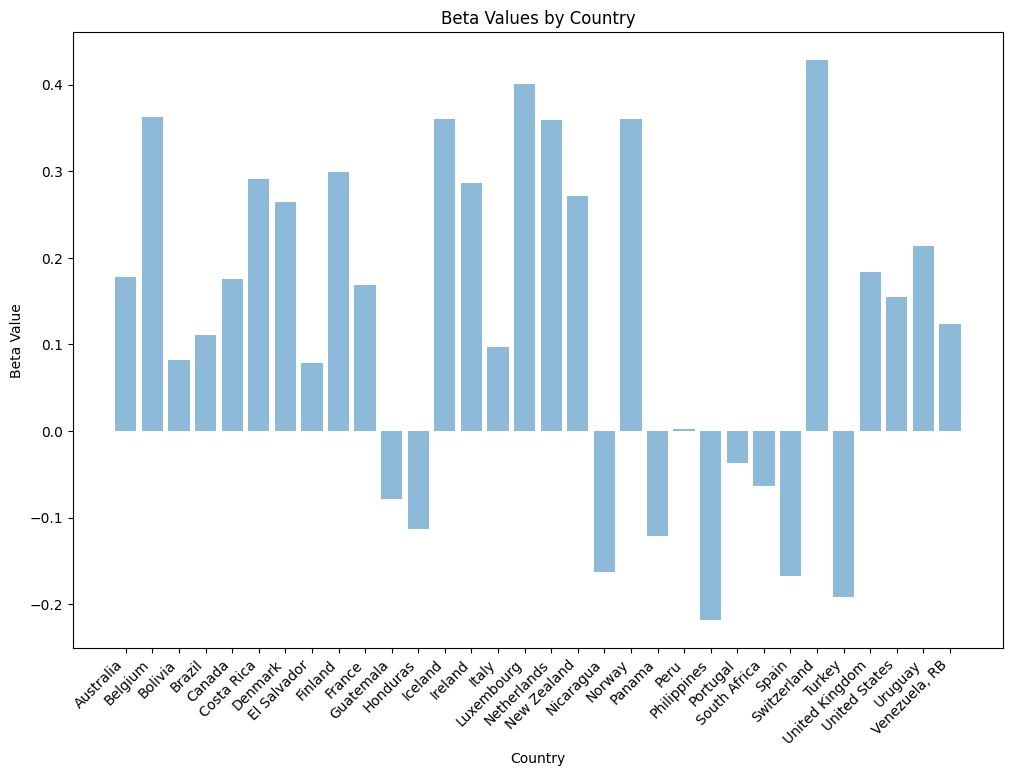

                            OLS Regression Results                            
Dep. Variable:            fhpolrigaug   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     11.98
Date:                Sun, 20 Oct 2024   Prob (F-statistic):           3.39e-39
Time:                        12:31:44   Log-Likelihood:                 110.63
No. Observations:                 363   AIC:                            -153.3
Df Residuals:                     329   BIC:                            -20.85
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0613      0.250      0.246      0.8

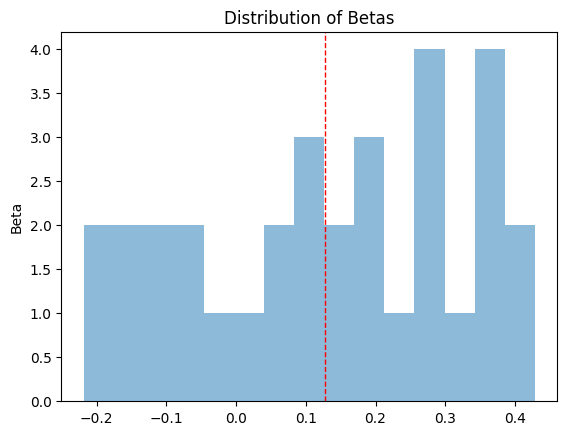

In [39]:
dummies = pd.get_dummies(df['country'], drop_first=True)

df_lsdv = pd.concat([df, dummies], axis=1, )
y = df_lsdv['fhpolrigaug']
x = df_lsdv[['lrgdpch','majorseas'] + list(dummies.columns)]

X = np.column_stack([np.ones(x.shape[0]), x])
xvars= ["cons"] + ['lrgdpch','majorseas'] + list(dummies.columns)

beta_hat_ols_LSDV, se_ols_LSDV, tstat_ols_LSDV, res_ols_LSDV, results_df_ols_LSDV = results_OLS(X,y, xvars)
print(results_df_ols_LSDV)
print("\n")

important_points = results_df_ols_LSDV["Australia":]
indexes = np.array(important_points.index)
values_of_beta = important_points["Beta"].values
mean = values_of_beta.mean()

plt.figure(figsize=(12,8))
plt.title("Beta Values by Country")
plt.xlabel("Country")
plt.ylabel("Beta Value")
y_pos = np.arange(len(indexes))
plt.bar(y_pos, values_of_beta, align='center', alpha=0.5)
plt.xticks(y_pos, indexes )
plt.xticks(rotation=45, ha='right')  # Adjust the rotation angle as needed
plt.show()

plt.title("Distribution of Betas")
plt.ylabel("Beta")
plt.hist(values_of_beta, bins = 15, alpha=0.5)
plt.axvline(mean, color='red', linestyle='--', linewidth=1)  
plt.plot


model_lsdv = sm.OLS(y, X)
results = model_lsdv.fit()
print(results.summary())

# plt.scatter( df_lsdv["lrgdpch"],res_ols_LSDV)
# plt.show()





## Long Difference Estimator 

In [40]:
longdifference_df = df.copy()
country_list = list(longdifference_df["country"].drop_duplicates()) 

for i in range(0, len(country_list)): 
    country = country_list[i]
    current_df = longdifference_df[longdifference_df["country"] == country]
    y = current_df['fhpolrigaug']
    x = current_df[['lrgdpch', 'majorseas']]
    year = current_df[current_df["year"]==1950]
    
    y_first = np.array(year["fhpolrigaug"])
    x_first = np.array(year[['lrgdpch', 'majorseas']])

    y_centered = y - y_first
    x_centered = x - x_first
    
    longdifference_df.loc[longdifference_df["country"] == country, 'fhpolrigaug_centered'] = y_centered
    longdifference_df.loc[longdifference_df["country"] == country, 'lrgdpch_centered'] = x_centered['lrgdpch']
    longdifference_df.loc[longdifference_df["country"] == country, 'majorseas_centered'] = x_centered['majorseas']

longdifference_df.to_excel("checkme.xlsx")
y = longdifference_df['fhpolrigaug_centered']
x = longdifference_df[['lrgdpch_centered']]
X = np.column_stack([np.ones(x.shape[0]), x])

xvars= ["cons", 'lrgdpch_centered']

beta_hat_ols_LD, se_ols_LD, tstat_ols_LD, res_ols_LD, results_df_ols_LD = results_OLS(X,y,xvars)
Omega = get_omega_fgls(res_ols_LD)
beta_hat_LD, se_LD, tstat_LD, res_LD, results_df_LD  = results_FGLS(X,y,Omega,xvars)
print(results_df_LD)
print("\n")

# plt.scatter( longdifference_df["fhpolrigaug_centered"],res_ols_LD)
# plt.show()

model_LD = sm.OLS(y, X)
ld_results = model_LD.fit()
print(ld_results.summary())


                      Beta  Standard Error    t-stat
cons             -0.022855        0.019115 -1.195679
lrgdpch_centered  0.064480        0.025904  2.489207


                             OLS Regression Results                             
Dep. Variable:     fhpolrigaug_centered   R-squared:                       0.017
Model:                              OLS   Adj. R-squared:                  0.014
Method:                   Least Squares   F-statistic:                     6.196
Date:                  Sun, 20 Oct 2024   Prob (F-statistic):             0.0133
Time:                          12:31:45   Log-Likelihood:                 22.511
No. Observations:                   363   AIC:                            -41.02
Df Residuals:                       361   BIC:                            -33.23
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std 

## First Difference Estimator

In [41]:
firstdifference_df = df.copy()
country_list = list(firstdifference_df["country"].drop_duplicates()) 
for i in range(0, len(country_list)): 
    country = country_list[i]
    firstdifference_df.loc[firstdifference_df["country"] == country, 'fhpolrigaug_t-1'] = firstdifference_df['fhpolrigaug'].shift(1)
    firstdifference_df.loc[firstdifference_df["country"] == country, 'lrgdpch_t-1'] = firstdifference_df['lrgdpch'].shift(1)
    firstdifference_df.loc[firstdifference_df["country"] == country, 'majorseas_t-1'] = firstdifference_df['majorseas'].shift(1)

firstdifference_df = firstdifference_df[firstdifference_df["year"]!=1950]
firstdifference_df["fhpolrigaug_fd"] = firstdifference_df["fhpolrigaug"] - firstdifference_df["fhpolrigaug_t-1"]
firstdifference_df["lrgdpch_fd"] = firstdifference_df["lrgdpch"] - firstdifference_df["lrgdpch_t-1"]
firstdifference_df["majorsea_fd"] = firstdifference_df["majorseas"] - firstdifference_df["majorseas_t-1"]

y = firstdifference_df['fhpolrigaug_fd']
x = firstdifference_df[['lrgdpch_fd']]
X = np.column_stack([np.ones(x.shape[0]), x])
xvars= ["cons", 'fhpolrigaug_fd']

beta_hat_ols_FD, se_ols_FD, tstat_ols_FD, res_ols_FD, results_df_ols_FD = results_OLS(X,y,xvars)
Omega = get_omega_fgls(res_ols_FD)
beta_hat_FD, se_FD, tstat_FD, res_FD, results_df_FD  = results_FGLS(X,y,Omega,xvars)
print(results_df_FD)

print("\n")

# plt.scatter( firstdifference_df["fhpolrigaug_fd"],res_FD)
# plt.show()

model_FD = sm.OLS(y, X)
fd_results = model_FD.fit()
print(fd_results.summary())


                    Beta  Standard Error    t-stat
cons            0.036279        0.014010  2.589444
fhpolrigaug_fd -0.240738        0.092826 -2.593438


                            OLS Regression Results                            
Dep. Variable:         fhpolrigaug_fd   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     6.726
Date:                Sun, 20 Oct 2024   Prob (F-statistic):            0.00993
Time:                        12:31:45   Log-Likelihood:                 82.700
No. Observations:                 330   AIC:                            -161.4
Df Residuals:                     328   BIC:                            -153.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t| 